In [30]:
"""# To update
!python -m pip uninstall -q tidy3d --yes
!pip install -q -e .
import os
os._exit(00)"""
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# tidy3D import
import tidy3d as td
from tidy3d import web
from tidy3d.plugins.mode import ModeSolver

In [50]:
THz = 1e12  # convertion factor from Hz to THz
freqs = np.linspace(0.4 * THz, 0.8 * THz, 100)  # freqeucny range of the simulation
freq0 = 0.6 * THz  # central frequency
freqw = 0.4 * THz  # width of the frequency range
lda0 = td.C_0 / freq0  # central wavelength
w_p = 0.69 * THz  # plasma frequency of Si
gamma = 0.83 * THz  # damping rate of Si
Si = td.Drude(
    eps_inf=11.7, coeffs=[(w_p, gamma)]
)  # using drude model to describe the response of silicon

loss_tan = 0.15  # loss tangent of PDMS
eps_pdms = 1.72 + 1j * 1.72 * loss_tan  # complex permittivity of PDMS
n_pdms = np.sqrt(eps_pdms)  # refractive index of PDMS
PDMS = td.Medium.from_nk(
    n=np.real(n_pdms), k=np.imag(n_pdms), freq=freq0
)  # define PDMS with the complex refractive index
p = 330  # unit cell size
h = 85  # height of the cylinder
r = 106  # radius of the cylinder
t = 8  # thickness of the substrate
# simulation domain size
# simulation size is the periodicity of the unit cell in x and y directions
# in z direction, the size is set to 2 central wavelength
Lx, Ly, Lz = p, p, 2 * lda0
sim_size = [Lx, Ly, Lz]

# construct the pdms substrate
substrate = td.Structure(
    geometry=td.Box(center=[0, 0, -t / 2], size=[td.inf, td.inf, t]), medium=PDMS
)

# construct the silicon resonator
cylinder = td.Structure(
    geometry=td.Cylinder(center=[0, 0, h / 2], radius=r, length=h, axis=2), medium=Si
)
# add a plane wave source
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=0.5 * freqw),
    size=(td.inf, td.inf, 0),
    center=(0, 0, 0.3 * lda0),
    direction="-",
    pol_angle=0,
)

# add a flux monitor to detect transmission
monitor_t = td.FluxMonitor(
    center=[0, 0, -0.4 * Lz], size=[td.inf, td.inf, 0], freqs=freqs, name="T"
)

# add a flux monitor to detect reflection
monitor_r = td.FluxMonitor(
    center=[0, 0, 0.4 * Lz], size=[td.inf, td.inf, 0], freqs=freqs, name="R"
)

# add a field monitor to see the field profile at the absorption peak frequency
monitor_field = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, lda0], freqs=[freq0], name="field"
)
run_time = 3e-10  # simulation run time

# set up simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=40, wavelength=lda0),
    structures=[substrate, cylinder],
    sources=[plane_wave],
    monitors=[monitor_t, monitor_r, monitor_field],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.periodic(), y=td.Boundary.periodic(), z=td.Boundary.pml()
    ),
    symmetry=(-1, 1, 0),
)  # symmetry can be used to greatly reduce the computational cost


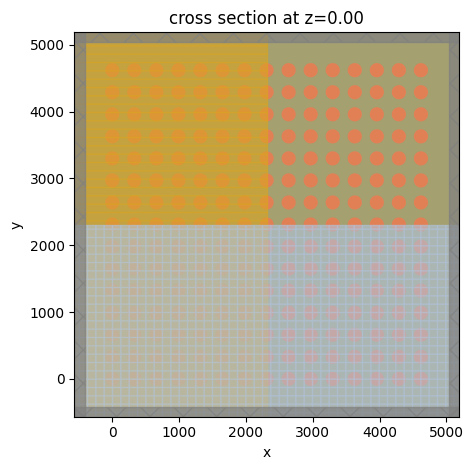

In [52]:
Nx = 15  # number of unit cells in the x direction
Ny = 15  # number of unit cells in the y direction
buffer = 0.5 * lda0  # buffer spacing in the x and y directions

# simulation domain size
Lx, Ly, Lz = Nx * p + 2 * buffer, Ny * p + 2 * buffer, 2 * lda0
sim_size = [Lx, Ly, Lz]

# systematicall construct the silicon resonators
metasurface = [substrate]
for i in range(Nx):
    for j in range(Ny):
        cylinder = td.Structure(
            geometry=td.Cylinder(
                center=[i * p, j * p, h / 2], radius=r, length=h, axis=2
            ),
            medium=Si,
        )
        metasurface.append(cylinder)

# define a gaussian beam with a waist radius of 3 wavelengths (focused beam)
gaussian = td.GaussianBeam(
    size=(td.inf, td.inf, 0),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=0.5 * freqw),
    center=(p * (Nx // 2), p * (Ny // 2), 0.3 * lda0),
    direction="-",
    waist_radius=3 * lda0,
)

# define a field monitor to visualize the field distribution under gaussian beam excitation
monitor_field = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, td.inf, 0], freqs=[freq0], name="field"
)

sim = td.Simulation(
    size=sim_size,
    center=(p * (Nx // 2), p * (Ny // 2), 0),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=30, wavelength=lda0),
    structures=metasurface,
    sources=[gaussian],
    monitors=[
        monitor_t,
        monitor_r,
        monitor_field,
    ],  # we will reuse the flux monitors defined earlier
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(
        boundary=td.PML()
    ),  # pml is applied in all boundaries
    symmetry=(-1, 1, 0),
)  # the same symmetry can be used

sim.plot(z=0)
plt.show()


plot
None None 2.4146647453308105
[0, 5000] [0, 5000] 2.219067096710205
[0, 4000] [0, 4000] 1.5753841400146484
[0, 3000] [0, 3000] 0.9688248634338379
[0, 2000] [0, 2000] 0.45558834075927734
[0, 1000] [0, 1000] 0.15032386779785156
[0, 500] [0, 500] 0.0754702091217041
plot_eps
None None 2.3118278980255127
[0, 5000] [0, 5000] 2.0619561672210693
[0, 4000] [0, 4000] 1.5865600109100342
[0, 3000] [0, 3000] 0.8725183010101318
[0, 2000] [0, 2000] 0.44435763359069824
[0, 1000] [0, 1000] 0.16916823387145996
[0, 500] [0, 500] 0.09513115882873535


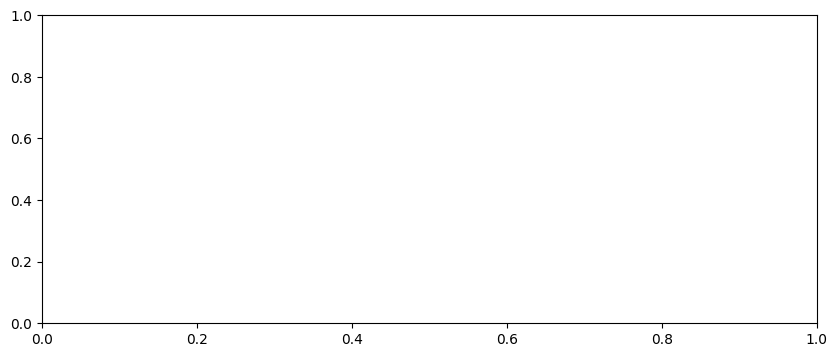

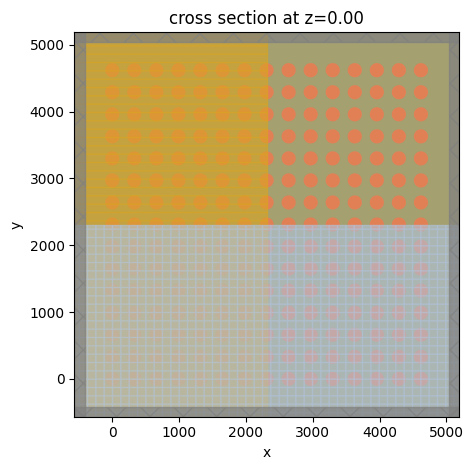

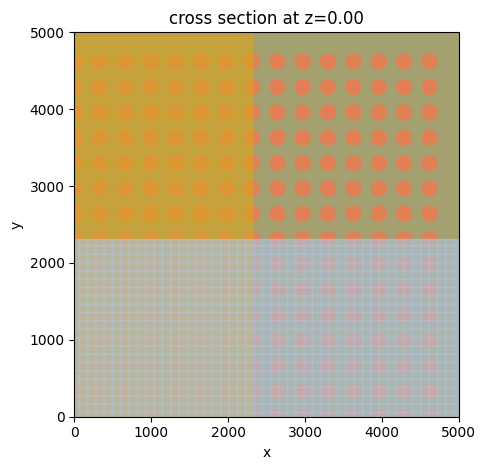

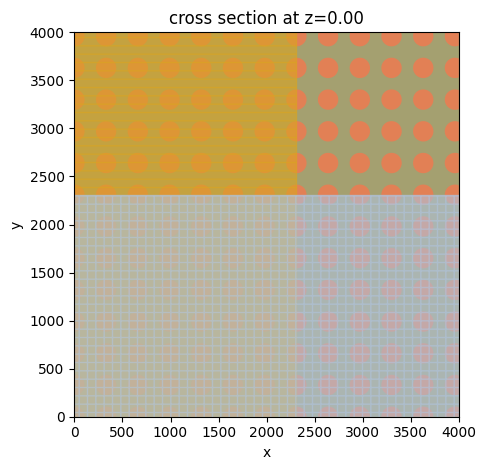

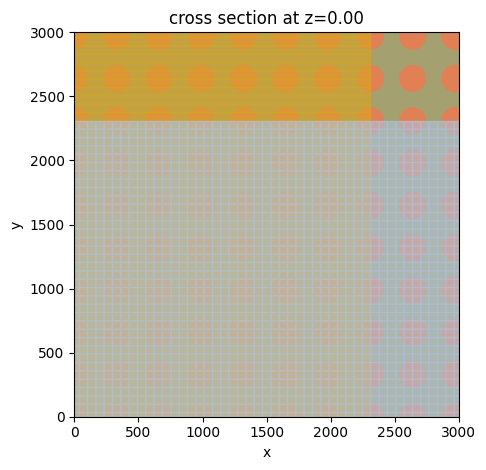

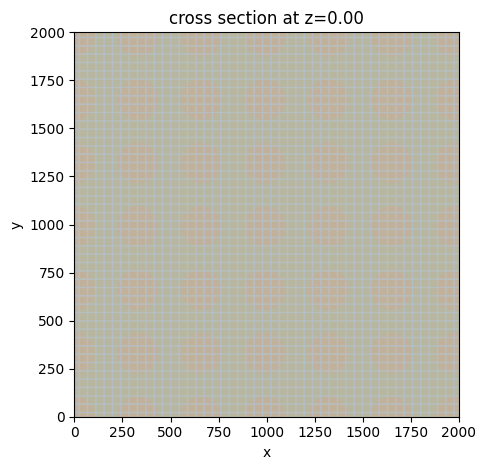

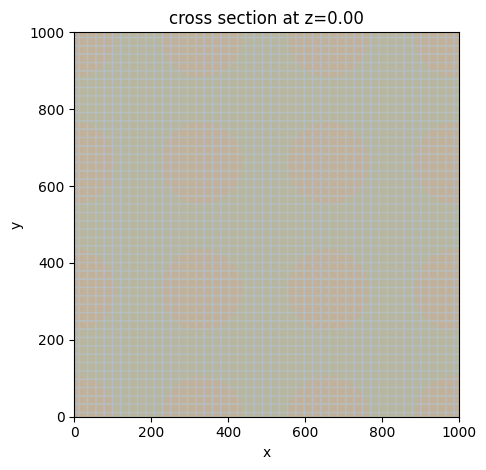

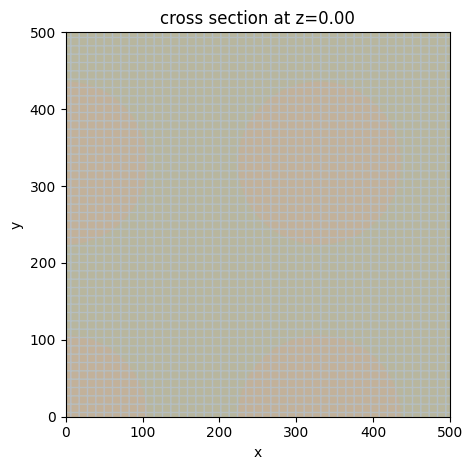

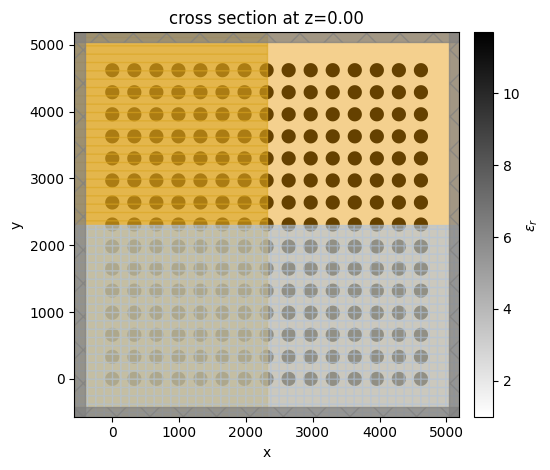

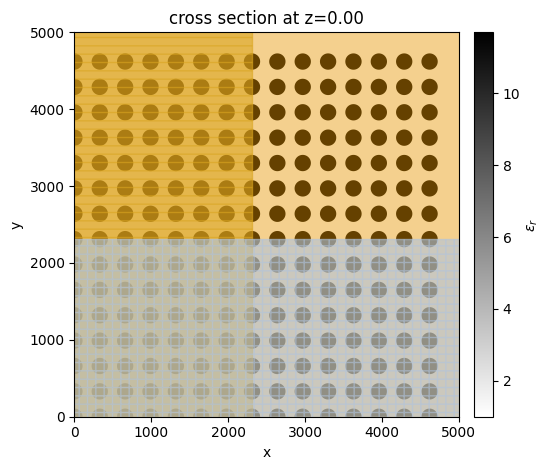

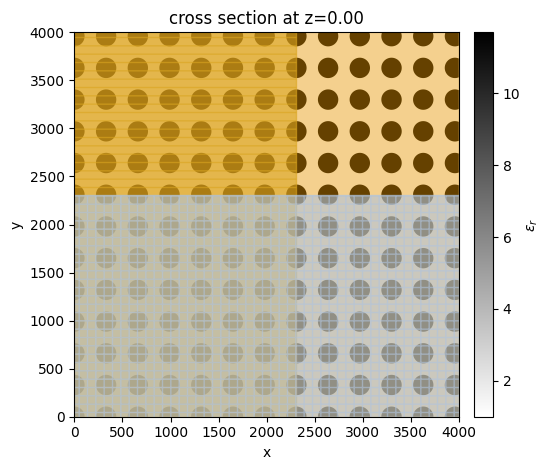

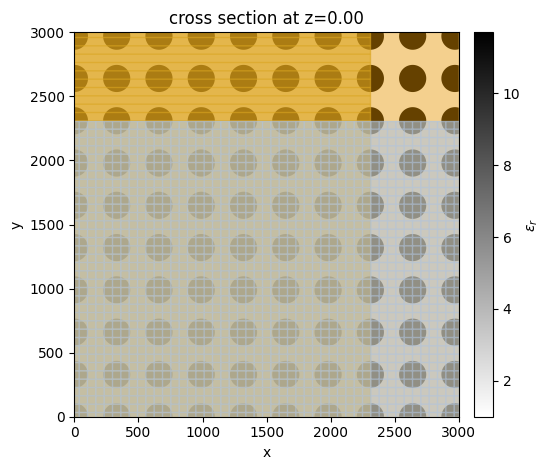

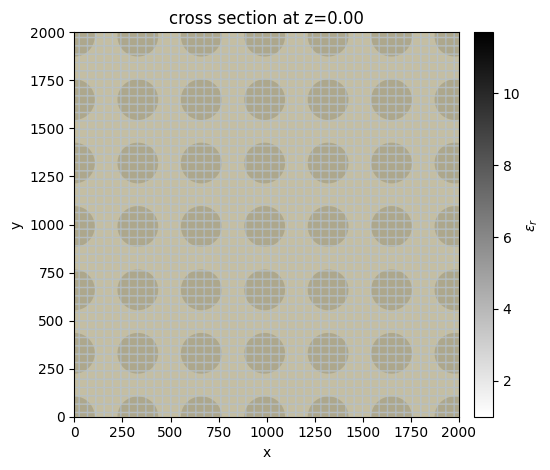

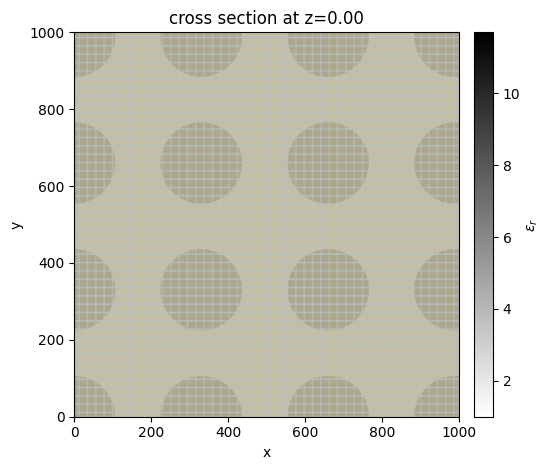

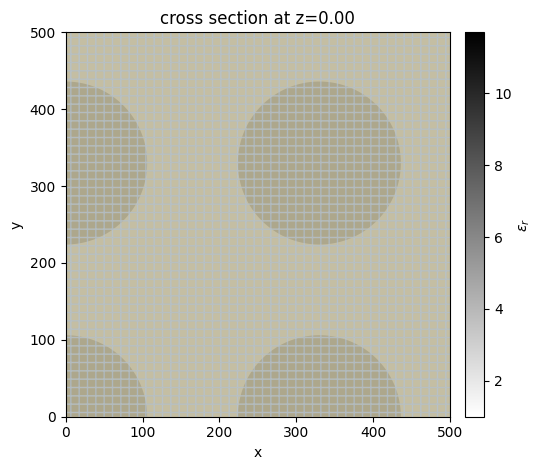

In [54]:
import time
lims = [[None,None],
        [[0,5000],[0,5000]],
        [[0,4000],[0,4000]],
        [[0,3000],[0,3000]],
        [[0,2000],[0,2000]],
        [[0,1000],[0,1000]],
        [[0,500],[0,500]]]

ts = []
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
print("plot:")
for l in lims:
    start_time = time.time()
    sim.plot(z=0, hlim=l[0], vlim=l[1]);
    time_to_plot = time.time() - start_time
    print(l[0],l[1], time_to_plot)
    ts.append(time_to_plot)
print("plot_eps:")
for l in lims:
    start_time = time.time()
    sim.plot_eps(z=0, hlim=l[0], vlim=l[1]);
    time_to_plot = time.time() - start_time
    print(l[0],l[1], time_to_plot)
    ts.append(time_to_plot)